# Autoencoder Demo

Demo of autoencoder trained on cartoon faces, I am hoping this will provide a better demo of generating new images by sampling latent vectors and allowing user to play with the slider (Latent Sliders)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import pickle
from glob import glob
import numpy as np
from time import time
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In this notebook, I am using Cartoon Set <a href="https://google.github.io/cartoonset/index.html">dataset</a> which I think will perform better than the Caricature dataset provided <a href="https://cvit.iiit.ac.in/research/projects/cvit-projects/cartoonfaces">here</a> because the cartoon set images have front facing face images whereas the other dataset also include whole body. There is a lot more variation for network to learn with the IIIT cartoonfaces dataset

In [4]:
dirname = "/mnt/bigdrive/datasets/cartoonset/cartoonset10k/"

In [5]:
fnames = glob('{}/*.png'.format(dirname))
len(fnames)

10000

In [6]:
path_ds = tf.data.Dataset.from_tensor_slices(fnames)
# print('shape: ', repr(path_ds.output_shapes))
# print('type: ', path_ds.output_types)

In [7]:
def load_preprocess_image(fname):
    image = tf.io.read_file(fname)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image /= 255.0
    return image

In [8]:
image_ds = path_ds.map(load_preprocess_image, num_parallel_calls=AUTOTUNE)

In [9]:
image_ds

<ParallelMapDataset shapes: (64, 64, 3), types: tf.float32>

In [10]:
def plot_images(images, grid=(2,2)):
    fig, axes = plt.subplots(grid[0], grid[1])
    for i, ds in enumerate(zip(axes.flat, images)):        
        ax, image = ds
        ax.imshow(image)
        ax.axis('off')
    plt.show()

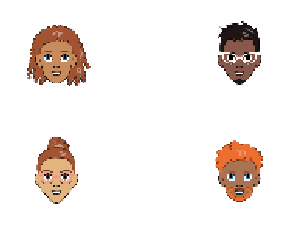

In [14]:
plot_images(image_ds.take(4))

# MODEL

Variational Autoencoder consists of encoder and decoder network just like vanilla autoencoder but instead of directly learning the latent vector $z$, the network learns the gaussian distribution mean and diagonal variance $(\mu, \sigma^2I)$

In [11]:
INPUT_SHAPE = (64,64,3)
LATENT_DIM = 32

### Encoder Network

We use conv layers for the encoder network

In [12]:
encoder_input = keras.Input(shape=(INPUT_SHAPE), name='encoder_input_image')
x = keras.layers.Conv2D(32, 4, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(64, 4, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2D(128, 4, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2D(256, 4, strides=(2,2), activation='relu')(x)
encoder_last_conv_shape = K.int_shape(x)[1:]
print("encoder_last_conv_shape: {}".format(encoder_last_conv_shape))
x = keras.layers.Flatten()(x)
mu = keras.layers.Dense(LATENT_DIM, activation='linear', name="mean")(x)
logvar = keras.layers.Dense(LATENT_DIM, activation='linear', name="variance")(x)

encoder = keras.Model(encoder_input, [mu, logvar], name='encoder')
encoder.summary()

encoder_last_conv_shape: (2, 2, 256)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_image (InputLayer [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 32)   1568        encoder_input_image[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   32832       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 128)    131200      conv2d_1[0][0]                   
_______________________________________________________

After the network has learned the distrubtion parameters, we need a way to sample the latent vector. We do this by creating a Lambda layer that accepts mean and variance as input and sampled latent vector $z$ as output.

In [13]:
def sample(args):
    mean, logvar = args
    # reparameterizaton trick: allows gradients to pass through the sample
    # 1. sample from unit gaussian, then
    # 2. multiply it with standard deviation and add mean
    e = tf.random.normal(shape=(K.shape(mean)[0], LATENT_DIM))
    return e * tf.math.exp(logvar) + mean

In [14]:
sampled_latent_vector = keras.layers.Lambda(sample)([mu, logvar])

### Decoder Network
For Decoder network, we sample the latent vector $z$ from the gaussian distribution and use it as input for our decoder network which is make of Deconv layers

In [15]:
decoder_input = keras.layers.Input(shape=K.int_shape(sampled_latent_vector)[1:], name='decoder_input')
x = keras.layers.Dense(np.prod(encoder_last_conv_shape))(decoder_input)
x = keras.layers.Reshape((1,1,np.prod(encoder_last_conv_shape)))(x)
x = keras.layers.Conv2DTranspose(128, kernel_size=5, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2DTranspose(64, kernel_size=5, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=6, strides=(2,2), activation='relu')(x)
decoder_output = keras.layers.Conv2DTranspose(3, kernel_size=6, strides=(2,2))(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33792     
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 128)         3276928   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        204864    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 30, 30, 32)        73760     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 3)         3459

### Loss

> VAEs train by maximising evidence lower bound (ELBO) on the marginal log-likelihood
$log\,p(x) >= \mathbb{E}_{q(z|x)} [ log \frac {p(x,z)} {q(z|x)}]$

>which is done by optimizing single sample Monte Carlo estimate of this expectation:
$ log\,p(x|z) + log\,p(z) - log\,q(z|x)$


Original Source: <a href="https://www.tensorflow.org/beta/tutorials/generative/cvae">Tensorflow Docs</a>


In [16]:
# Taken from tensorflow VAE example
def log_normal_pdf(sample, mean, logvar):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=1)

# @tf.function
def calculate_loss(mean, logvar, labels, decoded_logits):
    xent_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=decoded_logits)
    z = sample([mean, logvar])
    logpx_z = -tf.reduce_sum(xent_loss, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)
    return loss

### VAE Model

And finally, we create a model that combines encoder and decoder to build the VAE

In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def train_vars(self):
        return self.encoder.trainable_variables + self.decoder.trainable_variables
        
    def encode(self, x):
        encoded = self.encoder(x)
        return encoded
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits         

We then define the training step that performs the following operations on every batch
* take training data from batch and pass it through the encoder to approximate the parameters $(\mu \,,  \sigma^2)$ of posterior distribution
* sample latent variables from the posterior
* pass the samples to the decoder network to generated decoded logits
* calculate loss using decoded logits and training inputs
* compute and apply gradients

In [18]:
# Train step

# @tf.function
def train_step(train_x, model, optimizer):
    with tf.GradientTape() as tape:
        # use training inputs to approximate the posterior 
        mean, logvar = model.encode(train_x)
        # sample latent vector from the learned mean and variance
        latent_z = sample([mean, logvar])
        # decode z
        decoded_logits = model.decode(latent_z)
        # calculate loss            
        loss = calculate_loss(mean, logvar, labels=train_x, decoded_logits=decoded_logits)        
        
    # calculate gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

### DATASET

Next, we load the numpy dataset using Dataset api from tf.data and define parameters such as batch size, buffer size to shuffle the data

In [19]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = len(fnames)
train_dataset = image_ds \
    .shuffle(SHUFFLE_BUFFER_SIZE) \
    .repeat() \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE)

In [40]:
# Helper function to sample latent space and generate new images

def _plot_image(ax, image):
    ax.imshow(image)
    ax.axis('off')
    ax.set_aspect('equal')
    
def generate_sample_images(model, latent_z=None, plot_shape=(2,2), plot=True, save=False, save_name='toons/imgs/out.png', debug=False):
    if debug:
        print('generating samples')
        
    if latent_z is None:
        latent_z = tf.random.normal(shape=(np.prod(plot_shape), LATENT_DIM))
    # decode z
    decoded = model.decode(latent_z, apply_sigmoid=True)
    if plot:
        fig, axs = plt.subplots(plot_shape[0], plot_shape[1], figsize=(6, 6))                
        if np.prod(plot_shape) > 1:
            for i, ax in enumerate(axs.flat):
                image = decoded[i, :, :, :]
                _plot_image(ax, image)
    #             ax.imshow(decoded[i, :, :, :])
    #             ax.axis('off')
    #             ax.set_aspect('equal')
            plt.subplots_adjust(wspace=0, hspace=0)  
        else:
            image = decoded[0, :, :, :]
            _plot_image(axs, image)
    if save:
        plt.savefig(save_name)
        plt.show()

Now that we have all the ingredients in place, let's begin the training.
The following cell shows the main training loop.

In [21]:
# Number of training epochs
EPOCHS = 1000
# Initialize the Variational Autoencoder model 
model = VAE(encoder, decoder)
# Define optimizer
optimizer = keras.optimizers.Adam(1e-4)

# keep track of losses
losses = []

# How often to print the loss
print_every = max(int(0.1 * EPOCHS), 1)

# Model Checkpoint 
# Save model and optimizer
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model)
# Set save path and how many checkpoints to save
manager = tf.train.CheckpointManager(ckpt, './toons/ckpt/', max_to_keep=2)
# Load the latest checkpoint and restore
latest_ckpt = manager.latest_checkpoint
ckpt.restore(latest_ckpt)

if latest_ckpt:
    print('Restored from {}'.format(latest_ckpt))
else:
    print('Training from scratch')
# How often to save the checkpoint
save_every = max(int(0.3 * EPOCHS), 1)

# We are now ready to start the training loop
elapsed_loop_time = time()
for epoch in range(0, EPOCHS):
    for train_x in train_dataset:
        loss = train_step(train_x, model, optimizer)
        losses.append(loss)
    if epoch % print_every == 0:
        now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print('{}:vEpoch {}/{}: train loss {} in {} seconds'.format(epoch, EPOCHS, losses[-1], time()-elapsed_loop_time))         
        generate_sample_images(model, plot_shape=(4,4), save=True, save_name='./toons/imgs/img-{}.png'.format(epoch))
        elapsed_loop_time = time()
    if epoch % save_every == 0:
        save_path = manager.save()
        print('Saved checkpoint for step {}:{}'.format(epoch, save_path))
        
# Final Save
save_path = manager.save()
print('Saved checkpoint for step {}'.format(save_path))        

Restored from ./toons/ckpt/ckpt-5


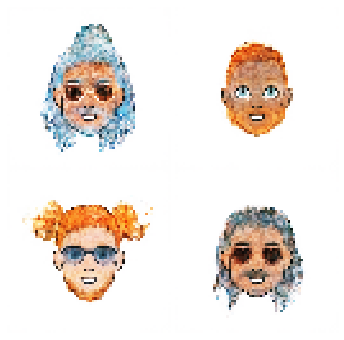

In [22]:
# Training
#10 + 500 + 10 + 1000 + 10000
generate_sample_images(model, plot_shape=(2,2))

# Latent Sliders
Lets play with the latent variables to see how they impact the generated cartoon

In [26]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [33]:
a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.VBox([
    widgets.HBox([a, b, c]),
    widgets.HBox([a, b, c]),
    widgets.HBox([a, b, c])])
def f(a, b, c):
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [82]:
def render_html(message):
    return widgets.HTML(
        value=message
    )

In [83]:
# Generate as many sliders as the number of latent dimensions
sliders = []
for i in range(LATENT_DIM):
    rnd = np.random.randn()
    slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.1, value=rnd, description='Slider {}'.format(i))
    sliders.append(slider)

num_widget_cols = 3
boxes = [widgets.HBox(sliders[i:i+num_widget_cols]) for i in range(0, len(sliders), num_widget_cols)]
boxes.insert(0, render_html('<H2>LATENT SLIDERS<H2>'))
boxes.insert(1, render_html('<p>Use the sliders to see its impact on the generated image</p>'))
ui = widgets.VBox(boxes)    
# ui = widgets.VBox(sliders)

In [84]:
def latent_slider_output(**kwargs):
    z = np.asarray([value for key, value in kwargs.items()])
    z = z.reshape((1,-1))
    generate_sample_images(model, latent_z=z, plot_shape=(1,1))
    
out = widgets.interactive_output(latent_slider_output, {'slider-{}'.format(i):v for i, v in enumerate(sliders)})

### Latent vector manipulation on cartoon image generated by variational autoencoder

Next, we will use the decoder from our variational autoencoder, that was trained on cartoon dataset, to show the impact of latent vector $Z$ manipulation on the image. By default, the sliders will be initialised by sampling the normal distribution.

In [85]:
# Generate UI
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 432x432 with 1 Axes>', 'i…

Here is what I found so far:

* Slider 0: Color
* Slider 2: Eyebrows
* Slider 5: Glasses
* Slider 6: Hair style
* Slider 7: Eyes
* Slider 9: Sunglasses
* Slider 11: Beard?
* Slider 12: Hairstyle too
* Slider 13: Gender and beard?
* Slider 14: Hair and gender
* Slider 15: Chin
* Slider 20: Hairline
* Slider 21: Gender and harstyle
* Slider 23: Hair
* Slider 25: Jawline
* Slider 27: removes glasses
* Slider 30: Hairline
* Slider 31: Gender and beard